In [39]:
from vis.input_modifiers import Jitter
from vis.callbacks import GifGenerator, Print
from vis.visualization import visualize_activation, visualize_saliency
from vis.utils import utils

from keras.applications.inception_v3 import InceptionV3
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Lambda, Input
from keras import backend as K
import keras

from keras_tqdm import TQDMCallback

import numpy as np
import matplotlib.pyplot as plt
%matplotlib nbagg
from sklearn.model_selection import train_test_split

In [35]:
def gen_omniglot(N = 2, n_samples_print=5):
    features = np.load('./Data/omniglot_inceptionV3_features.npy')
    n_classes, n_samples, n_features = features.shape
    classes = np.random.choice(np.arange(features.shape[0]), size=N, replace=False)
    images = np.load('./Data/omniglot.npy')
    n_classes, n_samples, n_pixels = images.shape
    imgs = np.reshape(images[classes, :, :], (N,n_samples, 28, 28))
    plt.figure(figsize=(N//2, 2))
    for i in range (N):
        for j in range(n_samples_print):
            plt.subplot2grid((n_samples_print, N), (j, i))
            img = imgs[i, j, ... ].squeeze()
            plt.imshow(img, cmap='Greys_r')
            plt.axis('off')
    X = np.reshape(images[classes, :, :], (N*n_samples, 28, 28, 1))
    y = np.repeat(np.arange(N), n_samples).reshape(N*n_samples, 1)
    return X, y

<IPython.core.display.Javascript object>


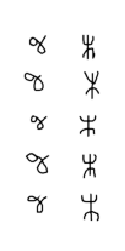

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [36]:
# sample a subset of omniglot
N=2
np.random.seed(0)
X, y = gen_omniglot(N=N)
X.shape, y.shape
# separate validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.5, stratify=y)

In [7]:
from keras.engine.topology import Layer

class L2Matching(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(L2Matching, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='Wp', 
                                      shape=(input_shape[1], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(L2Matching, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        diffs = K.stack([K.sum(K.square(x - K.transpose(self.kernel[:,j])), axis=-1) 
                         for j in range(self.output_dim)], axis=-1)  
        activ = K.softmax(-diffs)
        print(activ)
        return activ

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

def resize(x):
    x = K.resize_images(x, 5, 5, "channels_last")
    x = K.repeat_elements(x, 3, axis=-1)
    return x

In [37]:
img = Input(shape=(28, 28, 1))
rescaled_inputs = Lambda(resize)(img)
rescaled_inputs = Lambda(preprocess_input)(rescaled_inputs)
base_model = InceptionV3(include_top=False, weights='imagenet', input_tensor=rescaled_inputs)
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# prototype layer
#proto_activ = L2Matching(output_dim=20)(x)
proto_activ = Dense(6, activation='relu', use_bias='false')(x)
# final classifier
regL2 = keras.regularizers.l2(1)
predictions = Dense(10, activation='softmax', use_bias='false', kernel_regularizer=regL2)(proto_activ)

In [40]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optmizer = keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=optmizer, loss='categorical_crossentropy',
             metrics=['accuracy'])

# train the model on the new data for a few epochs
model.fit(X_train, keras.utils.to_categorical(y_train, 10), 
          batch_size=20, epochs=100, verbose=0, shuffle=True,
          validation_data=(X_val, keras.utils.to_categorical(y_val, 10)),
          callbacks=[TQDMCallback()])

Epoch: 0:   0%|          | 0/20 [00:00<?, ?it/s]
Epoch: 0 - loss: 0.098, acc: 1.000, val_loss: 8.119, val_acc: 0.500: 100%|██████████| 20/20 [00:04<00:00,  4.06it/s]
Epoch: 1:   0%|          | 0/20 [00:00<?, ?it/s]
Epoch: 1 - loss: 0.093, acc: 1.000, val_loss: 8.118, val_acc: 0.500: 100%|██████████| 20/20 [00:00<00:00, 68.25it/s]
Epoch: 2:   0%|          | 0/20 [00:00<?, ?it/s]
Epoch: 2 - loss: 0.089, acc: 1.000, val_loss: 8.117, val_acc: 0.500: 100%|██████████| 20/20 [00:00<00:00, 77.77it/s]
Epoch: 3:   0%|          | 0/20 [00:00<?, ?it/s]
Epoch: 3 - loss: 0.083, acc: 1.000, val_loss: 8.115, val_acc: 0.500: 100%|██████████| 20/20 [00:00<00:00, 77.05it/s]
Epoch: 4:   0%|          | 0/20 [00:00<?, ?it/s]
Epoch: 4 - loss: 0.080, acc: 1.000, val_loss: 7.712, val_acc: 0.500: 100%|██████████| 20/20 [00:00<00:00, 77.91it/s]
Epoch: 5:   0%|          | 0/20 [00:00<?, ?it/s]
Epoch: 5 - loss: 0.076, acc: 1.000, val_loss: 8.109, val_acc: 0.500: 100%|██████████| 20/20 [00:00<00:00, 77.72it/s]
Epoc

Epoch: 70:   0%|          | 0/20 [00:00<?, ?it/s]
Epoch: 70 - loss: 0.019, acc: 1.000, val_loss: 8.072, val_acc: 0.500: 100%|██████████| 20/20 [00:00<00:00, 77.43it/s]
Epoch: 71:   0%|          | 0/20 [00:00<?, ?it/s]
Epoch: 71 - loss: 0.019, acc: 1.000, val_loss: 8.072, val_acc: 0.500: 100%|██████████| 20/20 [00:00<00:00, 77.48it/s]
Epoch: 72:   0%|          | 0/20 [00:00<?, ?it/s]
Epoch: 72 - loss: 0.019, acc: 1.000, val_loss: 8.072, val_acc: 0.500: 100%|██████████| 20/20 [00:00<00:00, 78.02it/s]
Epoch: 73:   0%|          | 0/20 [00:00<?, ?it/s]
Epoch: 73 - loss: 0.018, acc: 1.000, val_loss: 8.072, val_acc: 0.500: 100%|██████████| 20/20 [00:00<00:00, 72.97it/s]
Epoch: 74:   0%|          | 0/20 [00:00<?, ?it/s]
Epoch: 74 - loss: 0.018, acc: 1.000, val_loss: 8.072, val_acc: 0.500: 100%|██████████| 20/20 [00:00<00:00, 76.78it/s]
Epoch: 75:   0%|          | 0/20 [00:00<?, ?it/s]
Epoch: 75 - loss: 0.018, acc: 1.000, val_loss: 8.072, val_acc: 0.500: 100%|██████████| 20/20 [00:00<00:00, 69.

In [32]:
l = model.layers_by_depth[1][0]

l, l.input_shape, l.output_shape, model.layers[-2]

(<keras.layers.core.Dense at 0x7f06f84dc630>,
 (None, 2048),
 (None, 6),
 <keras.layers.core.Dense at 0x7f06f84dc630>)

In [33]:
layer_idx = -2
model.layers[layer_idx].activation = keras.activations.linear
model = utils.apply_modifications(model)

NameError: name 'imagenet_utils' is not defined

In [61]:
from tqdm import tqdm
vis_images = []
for idx in tqdm(range(20)):
    img = visualize_activation(
        model, layer_idx,  idx,
        act_max_weight=1, lp_norm_weight=10, tv_weight=10, 
        max_iter=200, verbose=False, 
        input_modifiers=[Jitter()])
    vis_images.append(img)

100%|██████████| 20/20 [15:12<00:00, 45.63s/it]


<IPython.core.display.Javascript object>


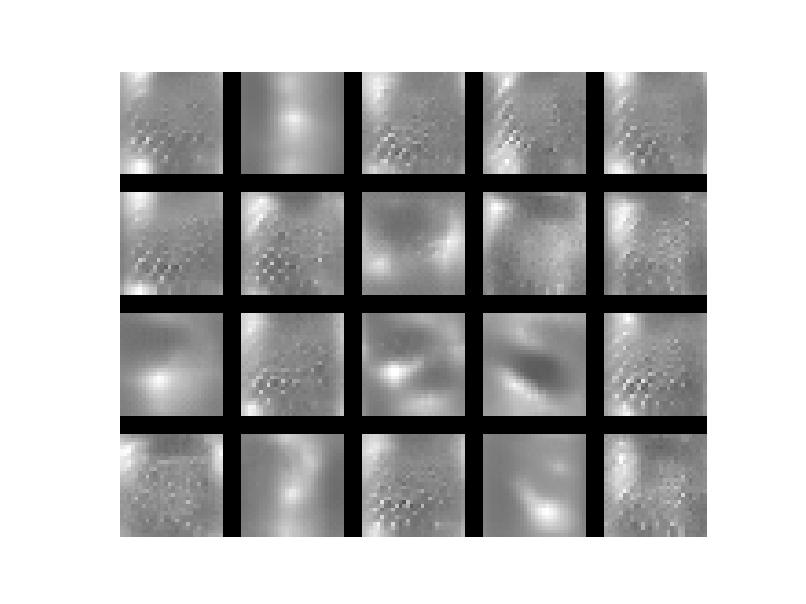

(-0.5, 159.5, 126.5, -0.5)

In [100]:
# Generate stitched image palette
stitched = utils.stitch_images(vis_images, cols=5)
plt.figure()
plt.imshow(stitched.squeeze(), cmap='Greys_r')
plt.axis('off')

To visualize saliency the best is to use some `backprop_modifier` e.g. `'guided'`. However that leads to a model modification and recompilation (call to `utils.apply_modifications`) which is veeeery slow.

In [76]:
seed_image = X[0,...]
vis_grads = []
for idx in tqdm([1,7,8,11]):
    grad = visualize_saliency(
        model, layer_idx,  idx,
        seed_input=seed_image)#,  
#         backprop_modifier='guided')
    vis_grads.append(grad)



  0%|          | 0/4 [00:00<?, ?it/s]
Exception in thread Thread-11:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 4/4 [02:34<00:00, 38.55s/it]


<IPython.core.display.Javascript object>


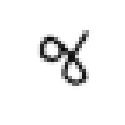

<IPython.core.display.Javascript object>


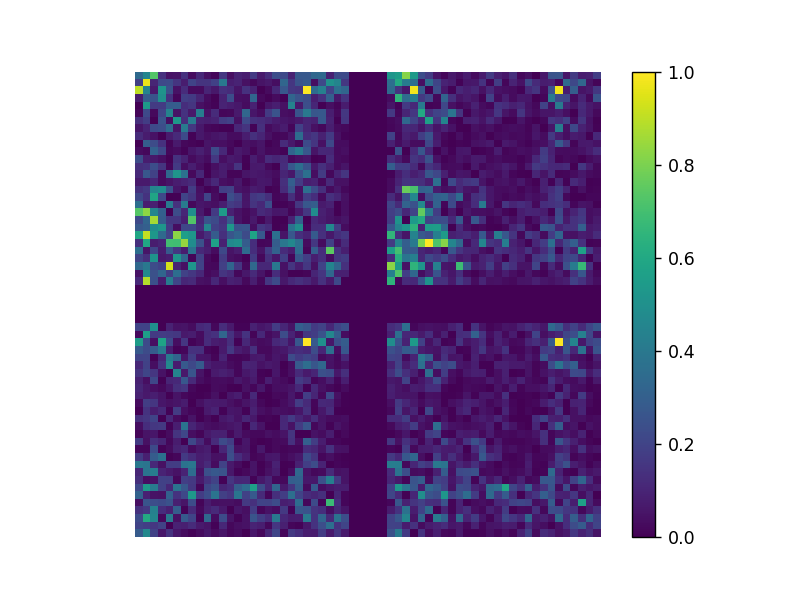

(-0.5, 60.5, 60.5, -0.5)

In [116]:
# Generate stitched image palette
vis_grads = [v.reshape(28,28,1) for v in vis_grads]
stitched = utils.stitch_images( vis_grads, cols=2)
plt.figure(figsize=(1,1))
plt.imshow(seed_image[...,0], cmap='Greys_r')
plt.axis('off')
plt.figure()
plt.imshow(stitched.squeeze(), cmap='viridis')
plt.colorbar()
plt.axis('off')


In [84]:
v = vis_grads[0]
v.reshape()

(28, 28)